In [59]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
!nvidia-smi

Mon Dec 16 20:46:47 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.104      Driver Version: 410.104      CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  Off  | 00000000:61:00.0 Off |                  Off |
| N/A   49C    P0    38W / 250W |   1941MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  Off  | 00000000:DB:00.0 Off |                  Off |
| N/A   50C    P0    44W / 250W |  11340MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [60]:
import pandas as pd

In [61]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [62]:
len(test_df)

410

In [63]:
len(train_df)

1589

In [65]:
from torch.utils.data import *
import cv2
import numpy as np
from torch.utils.data import DataLoader


class labelDataLoader(Dataset):
    def __init__(self, img_dir='data', imgSize=(94, 24), df=pd.read_csv('labels.csv'), is_transform=None):
        self.img_dir = img_dir
        self.map = {8: 0, 9: 1}
        self.img_paths = []
        self.labels = []
        for n, im in enumerate(df['img']):
            self.img_paths.append(os.path.join(img_dir, im))
            self.labels.append(df['val'][n])
        self.img_size = imgSize
        self.is_transform = is_transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        img_name = self.img_paths[index]
        img = cv2.imread(img_name)
        # img = img.astype('float32')
        resizedImage = cv2.resize(img, self.img_size)
        resizedImage = np.transpose(resizedImage, (2,0,1))
        resizedImage = resizedImage.astype('float32')
        resizedImage -= 127.5
        resizedImage *= 0.0078125
        lbl = self.labels[index]
        cl = self.map[len(lbl)]
        #cl = self.map[len(lbl)]
        return {"image": resizedImage, "labels": lbl, "vector": cl}


In [66]:
train_dataset = labelDataLoader(df=train_df)
test_dataset = labelDataLoader(df=test_df)
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=28, 
    shuffle=True, 
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=28, 
    shuffle=True, 
)

In [67]:
import matplotlib.pyplot as plt
for i, data in enumerate(train_loader):
    #inputs = data['image']
    #masks = data['labels']
    #gt = data["vector"]
    break


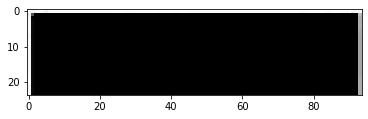

In [68]:
plt.imshow(data['image'][0].permute(1, 2, 0))

In [69]:
data['labels'][0]

'У318СУ62'

In [70]:
data['vector'][0]

tensor(0)

In [71]:
import matplotlib.pyplot as plt
for i, data in enumerate(test_loader):
    #inputs = data['image']
    #masks = data['labels']
    #gt = data["vector"]
    break


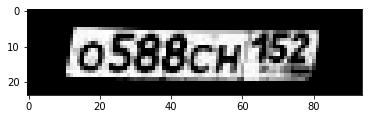

In [72]:
plt.imshow(data['image'][0].permute(1, 2, 0))

In [73]:
data['vector'][0]

tensor(1)

In [74]:
data['labels'][0]

'О588СН152'

In [75]:
from res import resnet18

In [76]:
import torch.nn as nn
import torch

model = resnet18().cuda()
criterion_CE = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

In [77]:
model.train()
print('train')

train


In [78]:
out = model(data['image'].cuda())

In [79]:
prediction = out.softmax(dim=1)

In [80]:
prediction

tensor([[0.0486, 0.9514],
        [0.1242, 0.8758],
        [0.2508, 0.7492],
        [0.2039, 0.7961],
        [0.2577, 0.7423],
        [0.3184, 0.6816],
        [0.3123, 0.6877],
        [0.4067, 0.5933],
        [0.2319, 0.7681],
        [0.2865, 0.7135],
        [0.3054, 0.6946],
        [0.2504, 0.7496],
        [0.2054, 0.7946],
        [0.1501, 0.8499],
        [0.3142, 0.6858],
        [0.2463, 0.7537],
        [0.2159, 0.7841],
        [0.3627, 0.6373],
        [0.1787, 0.8213],
        [0.2215, 0.7785],
        [0.2719, 0.7281],
        [0.2844, 0.7156],
        [0.2527, 0.7473],
        [0.3101, 0.6899],
        [0.1855, 0.8145],
        [0.2405, 0.7595],
        [0.2717, 0.7283],
        [0.2901, 0.7099]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [81]:
criterion_CE(out, data['vector'].cuda())

tensor(0.7265, device='cuda:0', grad_fn=<NllLossBackward>)

In [82]:
data['vector'].cuda().shape

torch.Size([28])

In [83]:
from tensorboardX import SummaryWriter
import shutil


PATH = '/cv/volume/experiments/num_estimator'
try:
    shutil.rmtree(PATH)
except:
    print("Cant clear")
    pass

In [84]:
writer = SummaryWriter(PATH)

In [85]:
import tqdm.notebook as tqdm
for epoch in tqdm.tqdm_notebook(range(50)):
    running_loss = 0.0
    model.train()
    for i, data in enumerate(train_loader):
        inputs = data['image'].cuda()
        gt = data['vector'].cuda()
        optimizer.zero_grad()
        out = model(inputs)
        prediction = out.softmax(dim=1)
        loss = criterion_CE(out, gt)
        loss.backward()
        optimizer.step()
        running_loss = loss.item()
        writer.add_scalar('train/loss_CE', running_loss, epoch * len(train_loader) + i)
        print(f"[TRAIN][BATCH {i}/{len(train_loader)}] {loss}\r", end="") 
        
    running_loss = 0.0
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            inputs = data['image'].cuda()
            gt = data['vector'].cuda()
            out = model(inputs)
            prediction = out.softmax(dim=1)
            loss = criterion_CE(out, gt)
            running_loss += loss.item()
            print(f"[VALID][BATCH {i}/{len(test_loader)}] {running_loss / (i + 1)}\r", end="")
            
        torch.save(model.state_dict(), os.path.join(PATH, str(epoch) + '.pth.tar'))

        writer.add_scalar('val/loss_CE', running_loss / len(test_loader), epoch)
            
            
    
        
        
        
        

[VALID][BATCH 14/15] 0.20634837833543618344


In [ ]:
import matplotlib.pyplot as plt
for i, data in enumerate(test_loader):
    #inputs = data['image']
    #masks = data['labels']
    #gt = data["vector"]
    break


In [ ]:
out = model(data['image'].cuda())
prediction = out.softmax(dim=1)
prediction.argmax(axis=1)[10]

In [ ]:
len(data['labels'][1])

In [ ]:
plt.imshow(data['image'][2].permute(1, 2, 0))

In [ ]:
dig = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "0"]
for n, i in enumerate(train_df['val']):
    if i[6] == "0": #or i[2] in dig:
        print(i, n)

In [ ]:
plt.imshow(cv2.imread("data/" + train_df.iloc[1072]['img']))